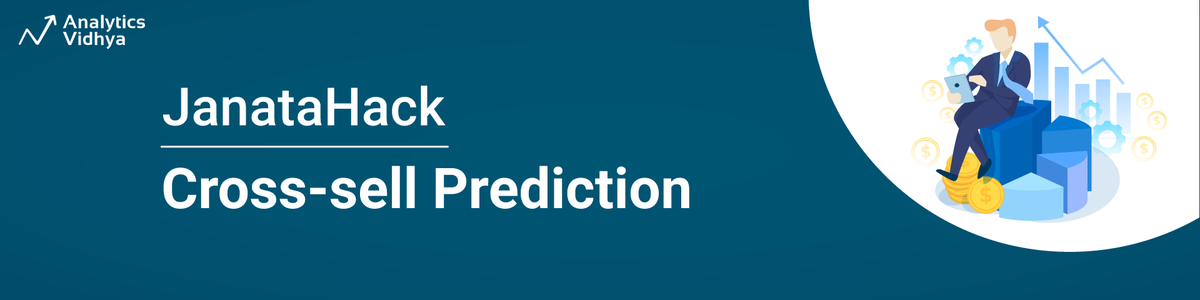

# Vehicle Insurance Prediction

### Problem Statement:
Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')

## Let's have a look at the data

In [3]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
#Get key info
print('\nNumber of rows: {}'.format(len(data)))
print('Number of columns: {}\n'.format(len(data.columns)))
data.describe()


Number of rows: 381109
Number of columns: 12



,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


## Let's check for balance in target class first

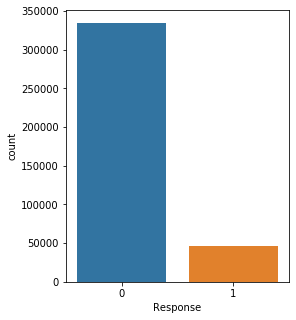

In [5]:
plt.figure(figsize=(4,5))
sns.countplot(data['Response'])

### Look's pretty unbalanced. We'll deal with that later

## What about null values?

In [6]:
data.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

## Let's check out all the binary data columns

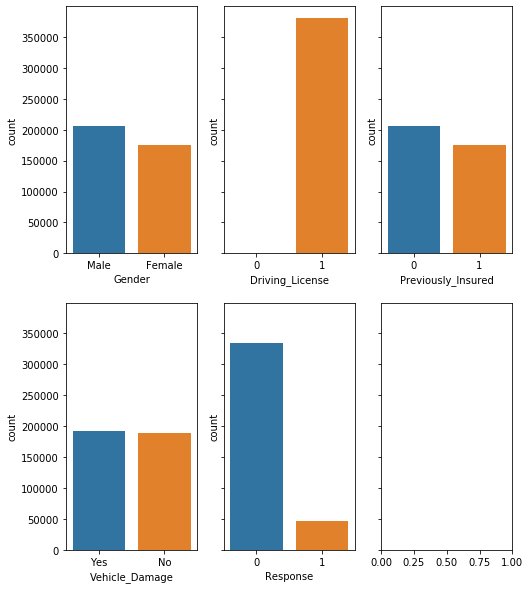

In [7]:
#Plot binary variables
bin_cols = [col for col in data.columns if data[col].nunique()==2]

fig, axes = plt.subplots(math.ceil(len(bin_cols)/3), 3, figsize=(8,10),sharey=True)
axes=axes.flatten()

for i in range(len(bin_cols)):
    sns.countplot(data[bin_cols[i]],ax=axes[i])

In [8]:
def plot_perc(x,y):
    '''
    Plots a bar giving the percent of every y in each group x
    '''
    (data.groupby(x)[y].value_counts(normalize=True).
     mul(100).rename('percent').reset_index().
     pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

### Let's see if responses are evenly distributed within each binary class

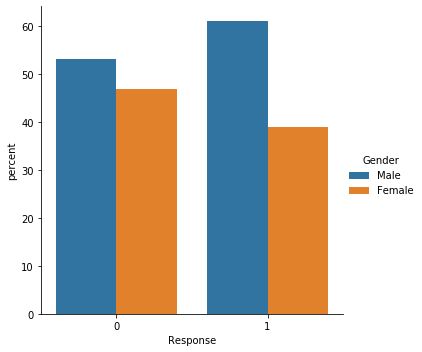

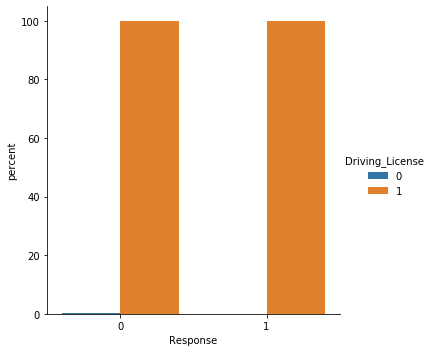

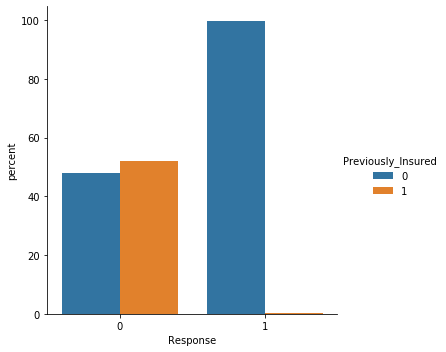

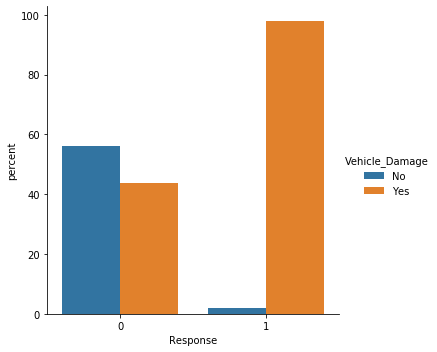

In [9]:
#Look at difference in responses within binary groups
for col in bin_cols:
    if col != 'Response':
        plot_perc('Response',col)

## What about the continuous variable columns?

In [10]:
#Continuous columns
num_cols = data.select_dtypes(include='number').columns
cont_cols = [col for col in num_cols if col not in bin_cols]

print(cont_cols)

['id', 'Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']


/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


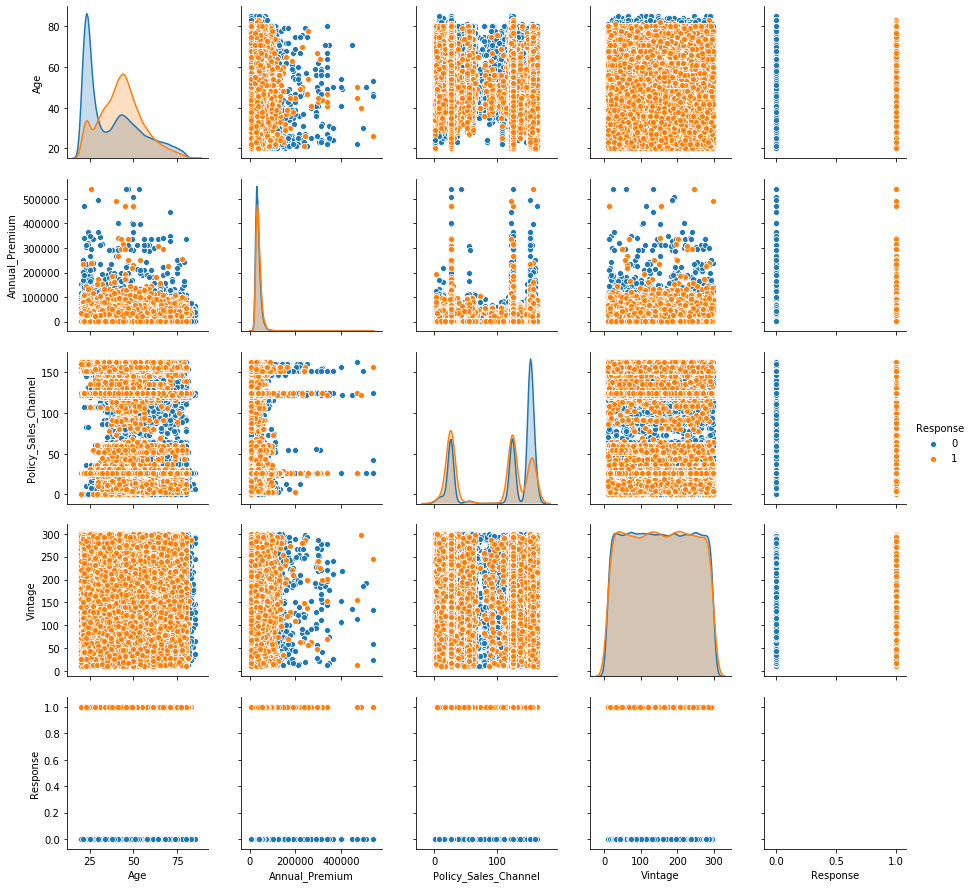

In [11]:
#Look at distribution of useful-looking continuous columns with response
sns.pairplot(data[['Age','Annual_Premium','Policy_Sales_Channel','Vintage','Response']],hue='Response')

### Age looks like it might be quite predictive of response

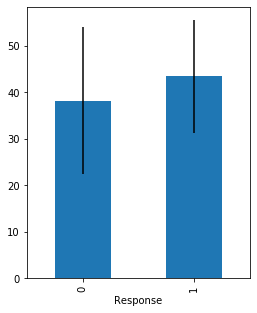

In [12]:
resp_gp=data.groupby('Response').agg([np.mean, np.std])
resp_gp['Age'].plot(kind='bar', y='mean', yerr = 'std', 
                    legend=False, figsize=(4,5))

#### Check distribution to see if need to normalize

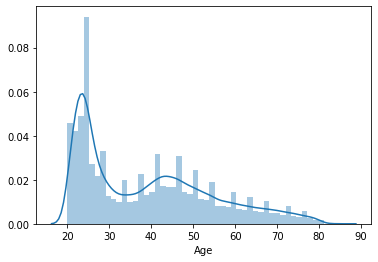

In [13]:
sns.distplot(data['Age'])

#### Clearly one-tailed: Try plotting median instead

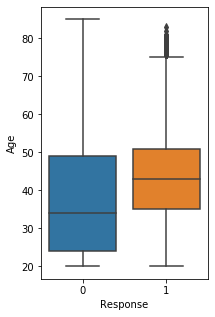

In [14]:
plt.figure(figsize=(3,5))
sns.boxplot(x=data['Response'],y=data['Age'])

## Annual Premium doesn't look hugely predictive but looks non-normal

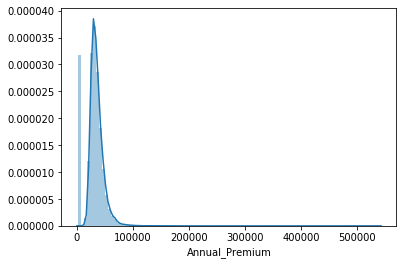

In [15]:
sns.distplot(data['Annual_Premium'],bins=100)

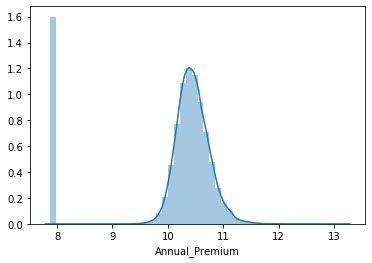

In [16]:
sns.distplot(np.log(data['Annual_Premium']))

### Looks like a there are a lot of low premiums

In [17]:
len(data[data['Annual_Premium'] < np.exp(8)])

#Create new column based on these low premiums
data['Low_Premium'] = (data['Annual_Premium'] < np.exp(8)) * 1

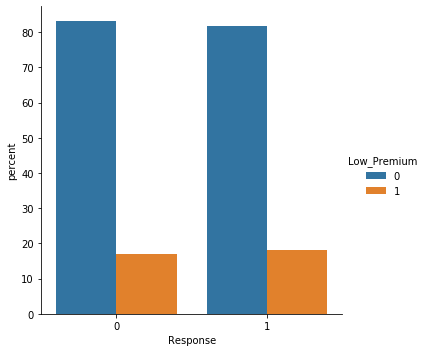

In [18]:
plot_perc('Response','Low_Premium')

### How many different values that meet low premium criteria are there?

In [19]:
print(data[data['Low_Premium']==1]['Annual_Premium'].nunique())
print(data[data['Low_Premium']==1]['Annual_Premium'].unique()[0])

1
2630.0


### For some reason loads of values are fixed at 2630
* Perhaps this is a minimum annual premium set by the company

## Check out data in vehicle age column

In [20]:
data['Vehicle_Age'].value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

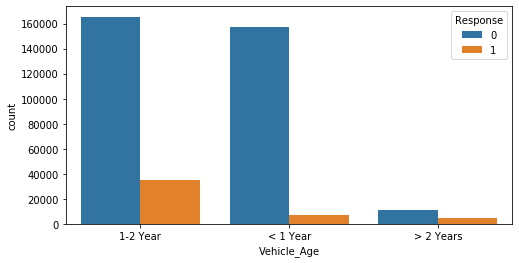

In [21]:
plt.figure(figsize=(8,4))
sns.countplot(data['Vehicle_Age'],hue=data['Response'],
             order = data['Vehicle_Age'].value_counts().index)

## Check out region codes


Number of regions: 53



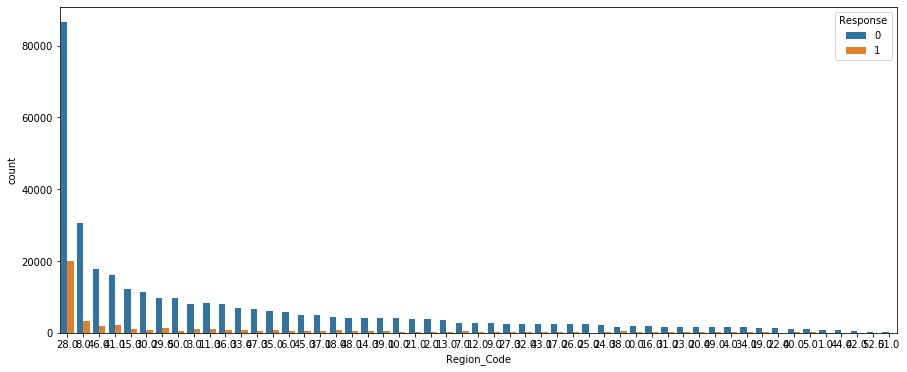

In [22]:
print('\nNumber of regions: {}\n'.format(data['Region_Code'].nunique()))
plt.figure(figsize=(15,6))
sns.countplot(data['Region_Code'],hue=data['Response'],
             order = data['Region_Code'].value_counts().index)

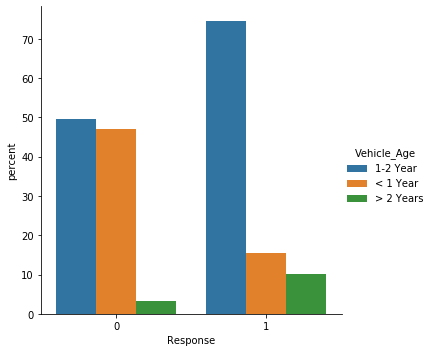

In [23]:
plot_perc('Response','Vehicle_Age')

## Let's check out any correlated measures

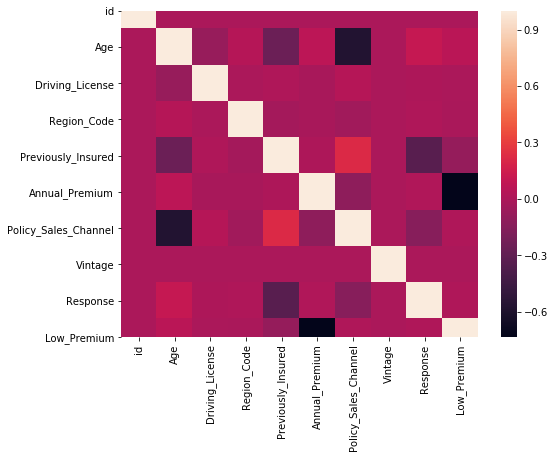

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr())

### ...and check out correlations of numeric columns with target

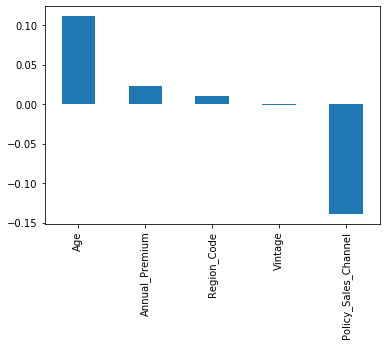

In [25]:
data[['Age','Region_Code','Annual_Premium','Policy_Sales_Channel','Vintage','Response']].corr()['Response'].sort_values(ascending=False)[1:].plot(kind='bar')

### Policy_Sales_Channel appears to be negatively correlated with target

155


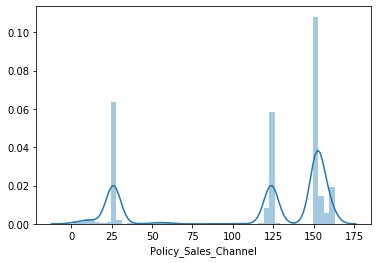

In [26]:
print(data['Policy_Sales_Channel'].nunique())
sns.distplot(data['Policy_Sales_Channel'])

# Data Prep for Models

In [27]:
data.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response', 'Low_Premium'],
      dtype='object')

## I'll make a data prep function so I can easily repeat the same data prep steps with train and test data

### This function will have a few options to try and improve the model:
* Log-normalize Annual_Premium column to see if this improves performance
* Add a column signifiying whether annual premium is at fixed lower bound

In [28]:
def prep_data(data,log_norm=True,incl_lp=True):
    '''
    Preps data into correct format for model
    
    Params:
           log_norm: Log-normalize Annual Premium column
           incl_lp: Include added low_premium column
    '''
    #Prep data
    cat_cols = ['Gender','Driving_License','Region_Code','Previously_Insured',
                'Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel','Low_Premium']

    X = data.drop(labels=['id'],axis=1)
    
    #Drop Response column
    if 'Response' in X.columns:
        X.drop(labels=['Response'],axis=1,inplace=True)
    
    #Remove Low_Premium column
    if not incl_lp:
        X.drop('Low_Premium',axis=1,inplace=True)
        cat_cols.remove('Low_Premium')
    else:
        if 'Low_Premium' not in X:
            #Create new column based on annual low premiums
            X['Low_Premium'] = (X['Annual_Premium'] < np.exp(8)) * 1
    
    #One-hot encode categorical columns
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    #Optionally normalize Annual Premuium column
    if log_norm:
        X['Annual_Premium'] = np.log(X['Annual_Premium'])
        
    return X

### We'll make a function to undersample the majority target class
#### This will:
* Make the data more balanced
* Reduce computation required to run model

In [29]:
from imblearn.under_sampling import RandomUnderSampler
def under_sample(X,y):
    '''
    Undersamples data for balanced targets
    '''
    column_names = X.columns
    rus = RandomUnderSampler()
    X, y = rus.fit_resample(X, y)
    X = pd.DataFrame(X,columns=column_names)
    
    return X, y

#### Function for model CV that we'll use later

In [46]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

def score_model(model,X,y,score_type='accuracy'):
    '''
    Run CV on inputted model
        
        - score_type is string for scoring metric to sue
    '''
    # CV model
    kfold = StratifiedKFold(n_splits=5)
    results = cross_val_score(model, X, y, 
                              cv=kfold, scoring=score_type,
                                  verbose=False)
    #Mean Results
    return results.mean()

### Prep training data

In [32]:
#Target column
y = data['Response']

#Run prep function
X = prep_data(data)

#Undersample to balance data
X, y = under_sample(X,y)

### Initially train-test-split data so can quickly get an idea of performance and trial different evaluation metrics (will move to CV later)

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Start with RFC for baseline model

In [36]:
#Random forest
from sklearn.ensemble import RandomForestClassifier

#Params estimated with prior run random search
RFC = RandomForestClassifier(n_estimators=500, 
                             min_samples_split=5, 
                             min_samples_leaf=1, 
                             max_features='auto', 
                             max_depth=None,
                             bootstrap=True)

In [37]:
#Fit model
RFC.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [38]:
predictions = RFC.predict(X_test)

In [39]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test,predictions))
print('\n')
print('ROC AUC Score: {}'.format(roc_auc_score(y_test,predictions)))

              precision    recall  f1-score   support

           0       0.87      0.69      0.77     13895
           1       0.75      0.90      0.81     14131

    accuracy                           0.79     28026
   macro avg       0.81      0.79      0.79     28026
weighted avg       0.81      0.79      0.79     28026



ROC AUC Score: 0.7929249107888815


## --- Use CV and test on full dataset ---

### Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

#Standard scale data for log. regression purposes
ss = StandardScaler()
X_lr = ss.fit_transform(X)

LR = LogisticRegressionCV()
LR_result = score_model(LR,X_lr,y,score_type='roc_auc') #We'll try scoring with roc_auc as per kaggle instructions
print(f'LR Score: {LR_result}')

/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it exp

LR Score: 0.8480506379959778


### Random Forest with CV

In [48]:
#Random forest with CV

#Params estimated with prior run random search
RFC_CV = RandomForestClassifier(n_estimators=500, 
                             min_samples_split=5, 
                             min_samples_leaf=1, 
                             max_features='auto', 
                             max_depth=None,
                             bootstrap=True)

RFC_result = score_model(RFC_CV,X,y,score_type='roc_auc')
print(f'RFC Score: {RFC_result}')

RFC Score: 0.8419885280852842


### XGBoost

In [49]:
#XGBoost
from xgboost import XGBClassifier

#Convert X so column names generic
X_xgb = pd.DataFrame(np.array(X))

XGB = XGBClassifier(n_estimators=500,learning_rate=0.01)

XGB_result = score_model(XGB,X_xgb,y,score_type='roc_auc')
print(f'XGB Score: {XGB_result}')

XGB Score: 0.8517188874208512


### LightGBM

In [50]:
from lightgbm import LGBMClassifier

#Light GBM
lgb = LGBMClassifier(n_estimators=200,learning_rate=0.01)
lgb_result = score_model(lgb,X,y,score_type='roc_auc')
print(f'LGBM: {lgb_result}')

/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


LGBM: 0.8544557349971523


### GradientBoostingClassifier

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

#Gradient Boosting Classifier
GBC = GradientBoostingClassifier(n_estimators=225,learning_rate=0.005)
gbc_result = score_model(GBC,X,y,score_type='roc_auc')
print(f'GBC Result: {gbc_result}')

GBC Result: 0.8383906463862051


### LightGBM appeared to perform modestly better than the rest

### Let's try some different options in the data_prep function to see if these change performance

In [51]:
# #Run prep function
X_v2 = prep_data(data,log_norm=False,incl_lp=False)
y_v2 = data['Response']

In [52]:
#Undersample to balance data
X_v2, y_v2 = under_sample(X_v2,y_v2)

In [53]:
from lightgbm import LGBMClassifier

#Light GBM
lgb = LGBMClassifier(n_estimators=200,learning_rate=0.01)
lgb_result = score_model(lgb,X_v2,y_v2,score_type='roc_auc')
print(f'LGBM: {lgb_result}')

LGBM: 0.8546442263608693


### ...very subtle improvement 


## Let's do some hyper-parameter tuning with LightGBM

In [61]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

rs_params = {
            'n_estimators': [100,200,300,500,800],
            'max_depth': sp_randint(10,50),
            'num_leaves': sp_randint(6, 50), 
            'learning_rate ': [0.1,0.01,0.001],
            'min_child_samples': sp_randint(10, 100), 
            'min_child_weight': [1e-4, 1e-3, 1e-2, 1e-1, 1],
            'subsample': sp_uniform(loc=0.2, scale=0.8), 
            'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
            'reg_alpha': [0, 1e-1, 1, 5, 10, 50, 100],
            'reg_lambda': [0, 1e-1, 1, 5, 10, 50, 100]
}

LGB = LGBMClassifier()
RS_LGBM = RandomizedSearchCV(estimator=LGB,
                           param_distributions=rs_params, 
                           cv=5,n_iter=50,verbose=2,scoring='roc_auc')

RS_LGBM.fit(X_v2,y_v2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] colsample_bytree=0.9544963515249089, learning_rate =0.001, max_depth=46, min_child_samples=84, min_child_weight=0.1, n_estimators=100, num_leaves=27, reg_alpha=1, reg_lambda=0.1, subsample=0.3972745880278794 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.9544963515249089, learning_rate =0.001, max_depth=46, min_child_samples=84, min_child_weight=0.1, n_estimators=100, num_leaves=27, reg_alpha=1, reg_lambda=0.1, subsample=0.3972745880278794, total=   2.2s
[CV] colsample_bytree=0.9544963515249089, learning_rate =0.001, max_depth=46, min_child_samples=84, min_child_weight=0.1, n_estimators=100, num_leaves=27, reg_alpha=1, reg_lambda=0.1, subsample=0.3972745880278794 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  colsample_bytree=0.9544963515249089, learning_rate =0.001, max_depth=46, min_child_samples=84, min_child_weight=0.1, n_estimators=100, num_leaves=27, reg_alpha=1, reg_lambda=0.1, subsample=0.3972745880278794, total=   2.2s
[CV] colsample_bytree=0.9544963515249089, learning_rate =0.001, max_depth=46, min_child_samples=84, min_child_weight=0.1, n_estimators=100, num_leaves=27, reg_alpha=1, reg_lambda=0.1, subsample=0.3972745880278794 
[CV]  colsample_bytree=0.9544963515249089, learning_rate =0.001, max_depth=46, min_child_samples=84, min_child_weight=0.1, n_estimators=100, num_leaves=27, reg_alpha=1, reg_lambda=0.1, subsample=0.3972745880278794, total=   2.1s
[CV] colsample_bytree=0.9544963515249089, learning_rate =0.001, max_depth=46, min_child_samples=84, min_child_weight=0.1, n_estimators=100, num_leaves=27, reg_alpha=1, reg_lambda=0.1, subsample=0.3972745880278794 
[CV]  colsample_bytree=0.9544963515249089, learning_rate =0.001, max_depth=46, min_child_samples=84, min_child_wei

[CV]  colsample_bytree=0.6395280772152283, learning_rate =0.01, max_depth=31, min_child_samples=43, min_child_weight=0.0001, n_estimators=300, num_leaves=21, reg_alpha=1, reg_lambda=1, subsample=0.7949388684371756, total=   3.5s
[CV] colsample_bytree=0.6395280772152283, learning_rate =0.01, max_depth=31, min_child_samples=43, min_child_weight=0.0001, n_estimators=300, num_leaves=21, reg_alpha=1, reg_lambda=1, subsample=0.7949388684371756 
[CV]  colsample_bytree=0.6395280772152283, learning_rate =0.01, max_depth=31, min_child_samples=43, min_child_weight=0.0001, n_estimators=300, num_leaves=21, reg_alpha=1, reg_lambda=1, subsample=0.7949388684371756, total=   3.6s
[CV] colsample_bytree=0.6395280772152283, learning_rate =0.01, max_depth=31, min_child_samples=43, min_child_weight=0.0001, n_estimators=300, num_leaves=21, reg_alpha=1, reg_lambda=1, subsample=0.7949388684371756 
[CV]  colsample_bytree=0.6395280772152283, learning_rate =0.01, max_depth=31, min_child_samples=43, min_child_weig

[CV]  colsample_bytree=0.6862898052754509, learning_rate =0.01, max_depth=43, min_child_samples=70, min_child_weight=0.1, n_estimators=500, num_leaves=38, reg_alpha=5, reg_lambda=100, subsample=0.9058637702918033, total=   7.1s
[CV] colsample_bytree=0.7502659113267542, learning_rate =0.001, max_depth=24, min_child_samples=10, min_child_weight=1, n_estimators=300, num_leaves=17, reg_alpha=10, reg_lambda=5, subsample=0.40750563303714016 
[CV]  colsample_bytree=0.7502659113267542, learning_rate =0.001, max_depth=24, min_child_samples=10, min_child_weight=1, n_estimators=300, num_leaves=17, reg_alpha=10, reg_lambda=5, subsample=0.40750563303714016, total=   3.7s
[CV] colsample_bytree=0.7502659113267542, learning_rate =0.001, max_depth=24, min_child_samples=10, min_child_weight=1, n_estimators=300, num_leaves=17, reg_alpha=10, reg_lambda=5, subsample=0.40750563303714016 
[CV]  colsample_bytree=0.7502659113267542, learning_rate =0.001, max_depth=24, min_child_samples=10, min_child_weight=1, 

[CV]  colsample_bytree=0.4905827287784652, learning_rate =0.01, max_depth=48, min_child_samples=87, min_child_weight=0.01, n_estimators=200, num_leaves=45, reg_alpha=50, reg_lambda=0, subsample=0.6896902546076699, total=   2.8s
[CV] colsample_bytree=0.4905827287784652, learning_rate =0.01, max_depth=48, min_child_samples=87, min_child_weight=0.01, n_estimators=200, num_leaves=45, reg_alpha=50, reg_lambda=0, subsample=0.6896902546076699 
[CV]  colsample_bytree=0.4905827287784652, learning_rate =0.01, max_depth=48, min_child_samples=87, min_child_weight=0.01, n_estimators=200, num_leaves=45, reg_alpha=50, reg_lambda=0, subsample=0.6896902546076699, total=   3.0s
[CV] colsample_bytree=0.7269992475310258, learning_rate =0.01, max_depth=37, min_child_samples=10, min_child_weight=0.01, n_estimators=100, num_leaves=32, reg_alpha=5, reg_lambda=50, subsample=0.8978376452819481 
[CV]  colsample_bytree=0.7269992475310258, learning_rate =0.01, max_depth=37, min_child_samples=10, min_child_weight=0

[CV]  colsample_bytree=0.6551389179656946, learning_rate =0.01, max_depth=24, min_child_samples=41, min_child_weight=0.01, n_estimators=200, num_leaves=42, reg_alpha=10, reg_lambda=10, subsample=0.3032870950944901, total=   3.5s
[CV] colsample_bytree=0.6551389179656946, learning_rate =0.01, max_depth=24, min_child_samples=41, min_child_weight=0.01, n_estimators=200, num_leaves=42, reg_alpha=10, reg_lambda=10, subsample=0.3032870950944901 
[CV]  colsample_bytree=0.6551389179656946, learning_rate =0.01, max_depth=24, min_child_samples=41, min_child_weight=0.01, n_estimators=200, num_leaves=42, reg_alpha=10, reg_lambda=10, subsample=0.3032870950944901, total=   3.4s
[CV] colsample_bytree=0.6551389179656946, learning_rate =0.01, max_depth=24, min_child_samples=41, min_child_weight=0.01, n_estimators=200, num_leaves=42, reg_alpha=10, reg_lambda=10, subsample=0.3032870950944901 
[CV]  colsample_bytree=0.6551389179656946, learning_rate =0.01, max_depth=24, min_child_samples=41, min_child_weig

[CV]  colsample_bytree=0.6277871878030186, learning_rate =0.1, max_depth=25, min_child_samples=36, min_child_weight=0.0001, n_estimators=300, num_leaves=30, reg_alpha=5, reg_lambda=100, subsample=0.7118962089051544, total=   4.4s
[CV] colsample_bytree=0.6277871878030186, learning_rate =0.1, max_depth=25, min_child_samples=36, min_child_weight=0.0001, n_estimators=300, num_leaves=30, reg_alpha=5, reg_lambda=100, subsample=0.7118962089051544 
[CV]  colsample_bytree=0.6277871878030186, learning_rate =0.1, max_depth=25, min_child_samples=36, min_child_weight=0.0001, n_estimators=300, num_leaves=30, reg_alpha=5, reg_lambda=100, subsample=0.7118962089051544, total=   4.5s
[CV] colsample_bytree=0.6277871878030186, learning_rate =0.1, max_depth=25, min_child_samples=36, min_child_weight=0.0001, n_estimators=300, num_leaves=30, reg_alpha=5, reg_lambda=100, subsample=0.7118962089051544 
[CV]  colsample_bytree=0.6277871878030186, learning_rate =0.1, max_depth=25, min_child_samples=36, min_child_w

[CV]  colsample_bytree=0.9708386264819129, learning_rate =0.1, max_depth=36, min_child_samples=31, min_child_weight=1, n_estimators=300, num_leaves=26, reg_alpha=0, reg_lambda=0.1, subsample=0.6694717541031603, total=   3.6s
[CV] colsample_bytree=0.9708386264819129, learning_rate =0.1, max_depth=36, min_child_samples=31, min_child_weight=1, n_estimators=300, num_leaves=26, reg_alpha=0, reg_lambda=0.1, subsample=0.6694717541031603 
[CV]  colsample_bytree=0.9708386264819129, learning_rate =0.1, max_depth=36, min_child_samples=31, min_child_weight=1, n_estimators=300, num_leaves=26, reg_alpha=0, reg_lambda=0.1, subsample=0.6694717541031603, total=   3.7s
[CV] colsample_bytree=0.9708386264819129, learning_rate =0.1, max_depth=36, min_child_samples=31, min_child_weight=1, n_estimators=300, num_leaves=26, reg_alpha=0, reg_lambda=0.1, subsample=0.6694717541031603 
[CV]  colsample_bytree=0.9708386264819129, learning_rate =0.1, max_depth=36, min_child_samples=31, min_child_weight=1, n_estimator

[CV]  colsample_bytree=0.6398726505557788, learning_rate =0.001, max_depth=29, min_child_samples=17, min_child_weight=0.0001, n_estimators=800, num_leaves=38, reg_alpha=5, reg_lambda=10, subsample=0.7979966400964993, total=   8.8s
[CV] colsample_bytree=0.4823438394849581, learning_rate =0.001, max_depth=21, min_child_samples=51, min_child_weight=1, n_estimators=300, num_leaves=43, reg_alpha=100, reg_lambda=0.1, subsample=0.6269554877623533 
[CV]  colsample_bytree=0.4823438394849581, learning_rate =0.001, max_depth=21, min_child_samples=51, min_child_weight=1, n_estimators=300, num_leaves=43, reg_alpha=100, reg_lambda=0.1, subsample=0.6269554877623533, total=   2.4s
[CV] colsample_bytree=0.4823438394849581, learning_rate =0.001, max_depth=21, min_child_samples=51, min_child_weight=1, n_estimators=300, num_leaves=43, reg_alpha=100, reg_lambda=0.1, subsample=0.6269554877623533 
[CV]  colsample_bytree=0.4823438394849581, learning_rate =0.001, max_depth=21, min_child_samples=51, min_child_w

[CV]  colsample_bytree=0.7493373116391471, learning_rate =0.1, max_depth=37, min_child_samples=63, min_child_weight=0.0001, n_estimators=200, num_leaves=10, reg_alpha=1, reg_lambda=100, subsample=0.6877288905276921, total=   2.7s
[CV] colsample_bytree=0.7493373116391471, learning_rate =0.1, max_depth=37, min_child_samples=63, min_child_weight=0.0001, n_estimators=200, num_leaves=10, reg_alpha=1, reg_lambda=100, subsample=0.6877288905276921 
[CV]  colsample_bytree=0.7493373116391471, learning_rate =0.1, max_depth=37, min_child_samples=63, min_child_weight=0.0001, n_estimators=200, num_leaves=10, reg_alpha=1, reg_lambda=100, subsample=0.6877288905276921, total=   2.6s
[CV] colsample_bytree=0.7255224919474732, learning_rate =0.001, max_depth=37, min_child_samples=29, min_child_weight=1, n_estimators=200, num_leaves=16, reg_alpha=5, reg_lambda=5, subsample=0.9209624307860513 
[CV]  colsample_bytree=0.7255224919474732, learning_rate =0.001, max_depth=37, min_child_samples=29, min_child_weig

[CV]  colsample_bytree=0.564390394097777, learning_rate =0.001, max_depth=40, min_child_samples=71, min_child_weight=0.1, n_estimators=100, num_leaves=13, reg_alpha=5, reg_lambda=5, subsample=0.7685584747857377, total=   1.9s
[CV] colsample_bytree=0.564390394097777, learning_rate =0.001, max_depth=40, min_child_samples=71, min_child_weight=0.1, n_estimators=100, num_leaves=13, reg_alpha=5, reg_lambda=5, subsample=0.7685584747857377 
[CV]  colsample_bytree=0.564390394097777, learning_rate =0.001, max_depth=40, min_child_samples=71, min_child_weight=0.1, n_estimators=100, num_leaves=13, reg_alpha=5, reg_lambda=5, subsample=0.7685584747857377, total=   1.8s
[CV] colsample_bytree=0.564390394097777, learning_rate =0.001, max_depth=40, min_child_samples=71, min_child_weight=0.1, n_estimators=100, num_leaves=13, reg_alpha=5, reg_lambda=5, subsample=0.7685584747857377 
[CV]  colsample_bytree=0.564390394097777, learning_rate =0.001, max_depth=40, min_child_samples=71, min_child_weight=0.1, n_es

[CV]  colsample_bytree=0.7895682459565281, learning_rate =0.01, max_depth=34, min_child_samples=50, min_child_weight=0.01, n_estimators=800, num_leaves=36, reg_alpha=0, reg_lambda=100, subsample=0.9448434065045588, total=  10.4s
[CV] colsample_bytree=0.7895682459565281, learning_rate =0.01, max_depth=34, min_child_samples=50, min_child_weight=0.01, n_estimators=800, num_leaves=36, reg_alpha=0, reg_lambda=100, subsample=0.9448434065045588 
[CV]  colsample_bytree=0.7895682459565281, learning_rate =0.01, max_depth=34, min_child_samples=50, min_child_weight=0.01, n_estimators=800, num_leaves=36, reg_alpha=0, reg_lambda=100, subsample=0.9448434065045588, total=  10.5s
[CV] colsample_bytree=0.7895682459565281, learning_rate =0.01, max_depth=34, min_child_samples=50, min_child_weight=0.01, n_estimators=800, num_leaves=36, reg_alpha=0, reg_lambda=100, subsample=0.9448434065045588 
[CV]  colsample_bytree=0.7895682459565281, learning_rate =0.01, max_depth=34, min_child_samples=50, min_child_weig

[CV]  colsample_bytree=0.6078514583988692, learning_rate =0.001, max_depth=35, min_child_samples=23, min_child_weight=0.1, n_estimators=100, num_leaves=20, reg_alpha=50, reg_lambda=0, subsample=0.4360168459390876, total=   1.8s
[CV] colsample_bytree=0.6078514583988692, learning_rate =0.001, max_depth=35, min_child_samples=23, min_child_weight=0.1, n_estimators=100, num_leaves=20, reg_alpha=50, reg_lambda=0, subsample=0.4360168459390876 
[CV]  colsample_bytree=0.6078514583988692, learning_rate =0.001, max_depth=35, min_child_samples=23, min_child_weight=0.1, n_estimators=100, num_leaves=20, reg_alpha=50, reg_lambda=0, subsample=0.4360168459390876, total=   1.9s
[CV] colsample_bytree=0.6078514583988692, learning_rate =0.001, max_depth=35, min_child_samples=23, min_child_weight=0.1, n_estimators=100, num_leaves=20, reg_alpha=50, reg_lambda=0, subsample=0.4360168459390876 
[CV]  colsample_bytree=0.6078514583988692, learning_rate =0.001, max_depth=35, min_child_samples=23, min_child_weight=

[CV]  colsample_bytree=0.8188833460382907, learning_rate =0.1, max_depth=39, min_child_samples=25, min_child_weight=0.1, n_estimators=500, num_leaves=22, reg_alpha=100, reg_lambda=100, subsample=0.7712497782326369, total=   3.8s
[CV] colsample_bytree=0.4212669455420466, learning_rate =0.1, max_depth=37, min_child_samples=47, min_child_weight=0.0001, n_estimators=200, num_leaves=10, reg_alpha=100, reg_lambda=50, subsample=0.7117248152772631 
[CV]  colsample_bytree=0.4212669455420466, learning_rate =0.1, max_depth=37, min_child_samples=47, min_child_weight=0.0001, n_estimators=200, num_leaves=10, reg_alpha=100, reg_lambda=50, subsample=0.7117248152772631, total=   2.0s
[CV] colsample_bytree=0.4212669455420466, learning_rate =0.1, max_depth=37, min_child_samples=47, min_child_weight=0.0001, n_estimators=200, num_leaves=10, reg_alpha=100, reg_lambda=50, subsample=0.7117248152772631 
[CV]  colsample_bytree=0.4212669455420466, learning_rate =0.1, max_depth=37, min_child_samples=47, min_child

[CV]  colsample_bytree=0.9151476404985064, learning_rate =0.001, max_depth=17, min_child_samples=60, min_child_weight=0.0001, n_estimators=200, num_leaves=8, reg_alpha=50, reg_lambda=10, subsample=0.903479828688418, total=   2.6s
[CV] colsample_bytree=0.9151476404985064, learning_rate =0.001, max_depth=17, min_child_samples=60, min_child_weight=0.0001, n_estimators=200, num_leaves=8, reg_alpha=50, reg_lambda=10, subsample=0.903479828688418 
[CV]  colsample_bytree=0.9151476404985064, learning_rate =0.001, max_depth=17, min_child_samples=60, min_child_weight=0.0001, n_estimators=200, num_leaves=8, reg_alpha=50, reg_lambda=10, subsample=0.903479828688418, total=   2.4s


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 16.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg...
                                        'n_estimators': [100, 200, 300, 500,
                                                 

In [62]:
print('Best score : {} with parameters: {} '.format(RS_LGBM.best_score_, RS_LGBM.best_params_))

Best score : 0.85711316622637 with parameters: {'colsample_bytree': 0.7171730726797689, 'learning_rate ': 0.1, 'max_depth': 31, 'min_child_samples': 33, 'min_child_weight': 1, 'n_estimators': 100, 'num_leaves': 17, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 0.3778878003190645} 


### Looks like random search gave us another modest improvement on score

* Given that we're using ROC_AUC unbalanced data not so much of a problem
* Let's now try the LGBM with best params on the full dataset to see if we can make any improvements in performance with that added data

### LightGBM on full dataset

In [64]:
#Prep full dataset

#Target column
y_full = data['Response']

#Run prep function
X_full = prep_data(data,log_norm=False,incl_lp=False) #Set options to false as didn't seem to improve performance

In [69]:
#Get list of best params from prev. model
best_params = RS_LGBM.best_params_

lgb_full = LGBMClassifier(**best_params)
lgb_full.set_params(**best_params)

lgb_result = score_model(lgb_full,X_full,y_full,score_type='roc_auc')
print(f'LGBM: {lgb_result}')

LGBM: 0.8575956459946571


### Again a subtle improvement
* Might we gain an improvement through oversampling?

In [70]:
from imblearn.over_sampling import RandomOverSampler
def over_sample(X,y):
    '''
    Undersamples data for balanced targets
    '''
    column_names = X.columns
    rus = RandomOverSampler()
    X, y = rus.fit_resample(X, y)
    X = pd.DataFrame(X,columns=column_names)
    
    return X, y

In [74]:
#Over-sample the minority class
X_over, y_over = over_sample(X_full,y_full)

#Check size looks right
print(f'Oversampled dataset rows: {len(X_over)}')

Oversampled dataset rows: 668798


In [75]:
lgb_over = LGBMClassifier(**best_params)
lgb_over.set_params(**best_params)

lgb_over_res = score_model(lgb_over,X_over,y_over,score_type='roc_auc')
print(f'LGBM: {lgb_over_res}')

LGBM: 0.8587390047577038
